In [1]:
import sys
import os
import copy
import pandas as pd
import numpy as np
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

sys.path.append('..\..')

import simple_network_sim.common as common
import simple_network_sim.loaders as loaders
import simple_network_sim.network_of_populations as ss
from simple_network_sim.sampleUseOfModel import build_args, runSimulation

def formatter(x, pos):
    if x == 0.:
        return "0"
    elif x < 1e3:
        return f"{x:,.0f}"
    elif x < 1e4:
        return f"{x / 1e3:,.1f}k"
    else:
        return f"{x / 1e3:,.0f}k"

fmt = ticker.FuncFormatter(lambda x, pos: formatter(x, pos))

In [2]:
def aggregate_all_boards(results):
    return results.groupby(["time", "state"]).sum().reset_index().pivot(index="time", columns="state", values="total")


def bump_progression_field(progression_file, compartment_1, compartment_2, bump):
    with open(progression_file) as fp:
        progression = loaders.readCompartmentRatesByAge(fp)

    progression_bumped = progression.copy()

    for age in progression_bumped.keys():
        assert progression_bumped[age][compartment_1][compartment_2] != 0., f"{compartment_1} to {compartment_2} is 0."
        diff = np.clip(bump + progression_bumped[age][compartment_1][compartment_2], 0., 1.) - progression_bumped[age][compartment_1][compartment_2]
        progression_bumped[age][compartment_1][compartment_2] += diff
        
        for compartment_to_adjust in progression_bumped[age][compartment_1]:
            if compartment_to_adjust != compartment_2:
                progression_bumped[age][compartment_1][compartment_to_adjust] -= diff / (len(progression_bumped[age][compartment_1]) - 1)
    
    return progression_bumped


def bump_infection_matrix(infectionMatrix, age_range1, age_range2, bump):
    infectionMatrix_bumped = copy.deepcopy(infectionMatrix)
    infectionMatrix_bumped._matrix[age_range1]._entries[age_range2] = max(0., infectionMatrix_bumped._matrix[age_range1]._entries[age_range2] + bump)
            
    return infectionMatrix_bumped


def bump_movement_multipliers(movementMultipliers, movement_bump, contact_bump, time_min=0, time_max=99e9):
    movementMultipliers_bumped = copy.deepcopy(movementMultipliers)
    
    for time in movementMultipliers:
        if time_min <= time <= time_max:
            movementMultipliers_bumped[time] = loaders.Multiplier(max(0., movementMultipliers_bumped[time].movement + movement_bump), max(0., movementMultipliers_bumped[time].contact + contact_bump))

    return movementMultipliers_bumped


def tilt_movement_multipliers(movementMultipliers, movement_bump, contact_bump, time_min=0, time_max=99e9):
    movementMultipliers_bumped = copy.deepcopy(movementMultipliers)
    
    time_max = list(movementMultipliers_bumped.keys())[-1]
    
    for time in movementMultipliers:
        if time_min <= time <= time_max:
            movementMultipliers_bumped[time] = loaders.Multiplier(max(0., movementMultipliers_bumped[time].movement + movement_bump * time / time_max), max(0., movementMultipliers_bumped[time].contact + contact_bump * time / time_max))

    return movementMultipliers_bumped


def plot_movement_multiplier(ax, label, bumped_multipliers):
    bumped = np.array([m.movement for m in bumped_multipliers.values()])
    ax.plot(list(bumped_multipliers.keys()), bumped, label=label)
    ax.set_title("Movement multiplier")
    ax.set_xlabel('')
    ax.legend()
    
    
def plot_contact_multiplier(ax, label, bumped_multipliers):
    bumped = np.array([m.contact for m in bumped_multipliers.values()])
    ax.plot(list(bumped_multipliers.keys()), bumped, label=label)
    ax.set_title("Contact multiplier")
    ax.set_xlabel('')
    ax.legend()


def get_initial_infections(initialInfections):
    with open(initialInfections) as fp:
        return([loaders.readInitialInfections(fp)])


def create_original_network(args):

    return ss.createNetworkOfPopulation(
        diseasesProgressionFn=args.compartment_transition,
        populationFn=args.population,
        graphFn=args.commutes,
        ageInfectionMatrixFn=args.mixing_matrix,
        movementMultipliersFn=args.movement_multipliers,
        infectiousStates=args.infectious_states.split(","),
    )


def create_network(progression, states, graph, infectionMatrix, movementMultipliers, infectiousStates):    
    return ss.NetworkOfPopulation(copy.deepcopy(progression), copy.deepcopy(states), copy.deepcopy(graph), copy.deepcopy(infectionMatrix), copy.deepcopy(movementMultipliers), copy.deepcopy(infectiousStates))

As a starting point we use a set of realistic (yet not final) parameters for disease evolution, provided by Jessica Enright.

In [3]:
parent_dir = Path(os.path.abspath('')).parents[1]

argv = [
    '--movement-multipliers', 'trialMultipliers.logical.csv', 
    '--compartment-transition', 'paramsFromSCovMod.csv',
    '--mixing-matrix', 'simplified_age_infection_matrix_from_comix.csv',
    '--population', str(parent_dir / 'sample_input_files/sample_hb2019_pop_est_2018_row_based.csv'),
    '--commutes', str(parent_dir / 'sample_input_files/sample_scotHB_commute_moves_wu01.csv'),
    'seeded', 'casesByHBMarch15.csv', 'logical.csv']
args = build_args(argv, inputFilesFolder="doc/notebooks")

max_time = 200
trials = 1

# 1) Parameters description

### a) Compartment transitions

Compartment transition describe the probability of each individual in each of the seven disease states (Exposed, Asymptomatic, Infectious, Recovered, Dead, Hosplitalized) to progress to next level of the disease.

In [4]:
with open(args.compartment_transition) as fp:
    progression = loaders.readCompartmentRatesByAge(fp)
    
pd.concat([pd.DataFrame(f) for f in progression.values()], keys=progression.keys(), axis=1).style.set_precision(2).background_gradient("Reds", high=0.5).highlight_null("black")

C:\Users\gorokf\Anaconda3\envs\simple_network_sim\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


### b) Movement and contact multipliers

These multipliers are applied to movement and contact and allow dampening of the transmission to account for quarantine, people behaving safer, etc.

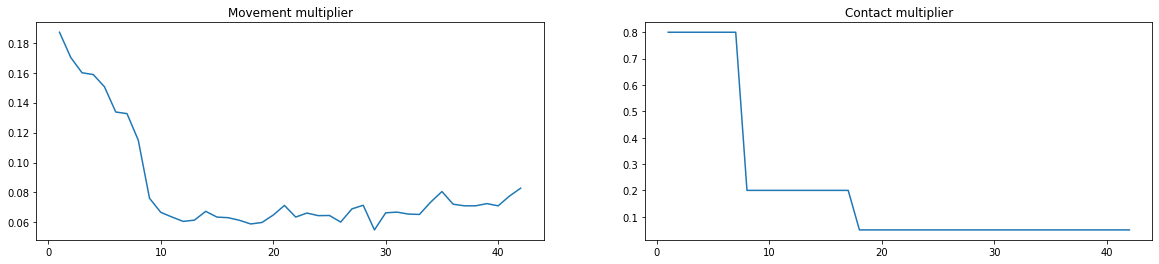

In [5]:
with open(args.movement_multipliers) as fp:
    movementMultipliers = loaders.readMovementMultipliers(fp)
    
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
axes[0].plot(list(movementMultipliers.keys()), [m.movement for m in movementMultipliers.values()])
axes[0].set_title("Movement multiplier")

axes[1].plot(list(movementMultipliers.keys()), [m.contact for m in movementMultipliers.values()])
axes[1].set_title("Contact multiplier");

### c) Infection matrix

The infection matrix stores the expected numbers of interactions between people of different ages. Each of these interactions leads to an infection. Several interactions can target the same person.

In [6]:
print(loaders.MixingMatrix(args.mixing_matrix))

[0,17): [[0,17): 2.158825495, [17,70): 1.64281058, 70+: 0.095392626]
[17,70): [[0,17): 0.540817942, [17,70): 2.29122061, 70+: 0.175799206]
70+: [[0,17): 0.036736215, [17,70): 0.274034061, 70+: 0.07521727]


### d) Population

The initial population per scottish health board (an health board is broadly a large region/county of scotland). There are 14 in total, for a global population of 5.4mm individuals.

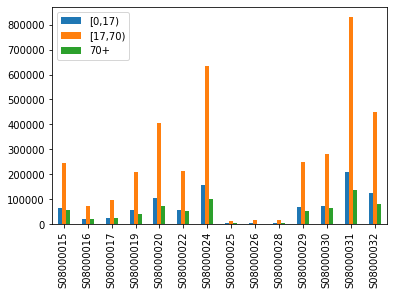

In [7]:
with open(args.population) as fp:
    population = loaders.readPopulationAgeStructured(fp)
    
pd.DataFrame(population).T.plot.bar()

### e) Initial infections

Initial infections represent the number of infected people at the beginning of the crisis, per health board, as of 15 March 2020.

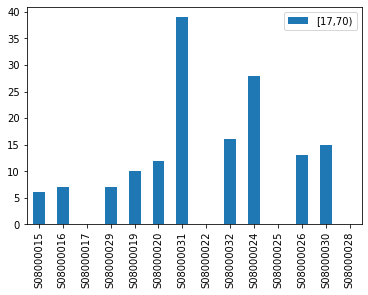

In [8]:
with open(args.input) as fp:
    initialInfections = loaders.readInitialInfections(fp)
    
pd.DataFrame(initialInfections).T.plot.bar()

# 2) Parameter sensitivity analysis

### a) Baseline run

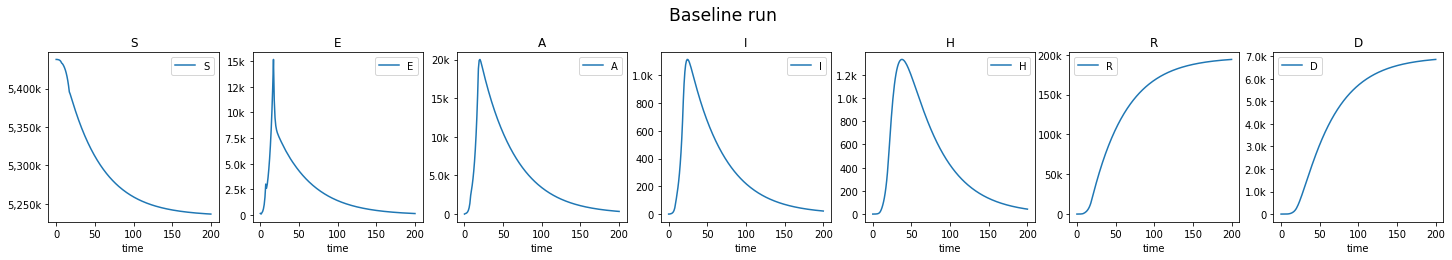

In [9]:
network = create_original_network(args)
initialInfections = get_initial_infections(args.input)
res = runSimulation(network, max_time, trials, initialInfections)
res = aggregate_all_boards(res)

fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(25, 3.5), sharex=True)
fig.suptitle(f"Baseline run", fontsize='xx-large')
fig.subplots_adjust(top=0.8)
for i, col in enumerate(['S', 'E', 'A', 'I', 'H', 'R', 'D']):
    res[col].plot(ax=axes[i], title=col)
    axes[i].legend()
    axes[i].yaxis.set_major_formatter(fmt)

### b) Sensitivity to compartment transition matrix probabilities

We notice that the most impactful parameters are the transmission probabilities from the asymptomatic class. Both the probabilities starting from exposed, infectious and hospitalized, while having an impact, have a more marginal one.

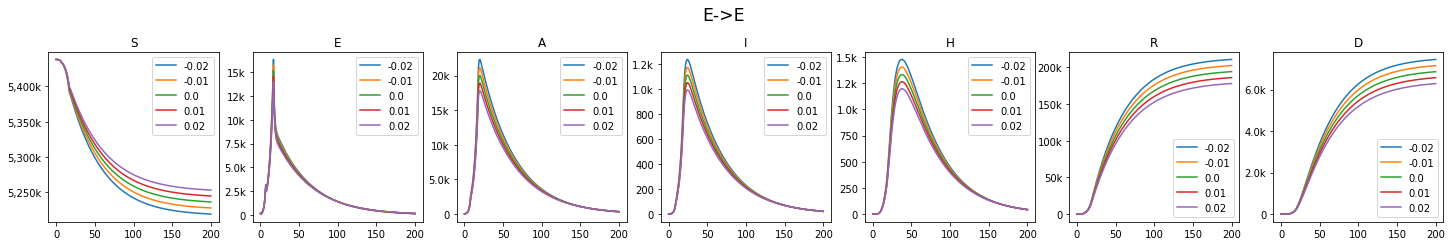

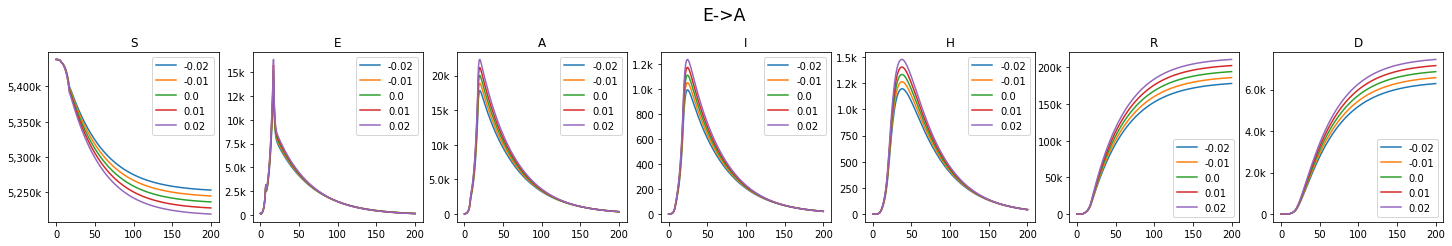

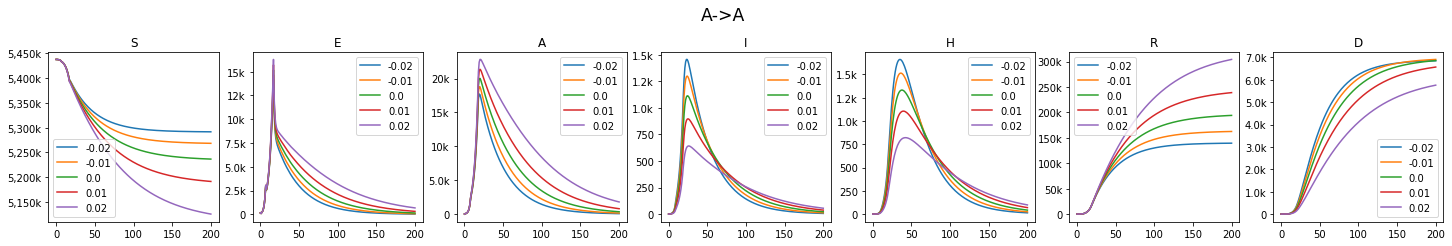

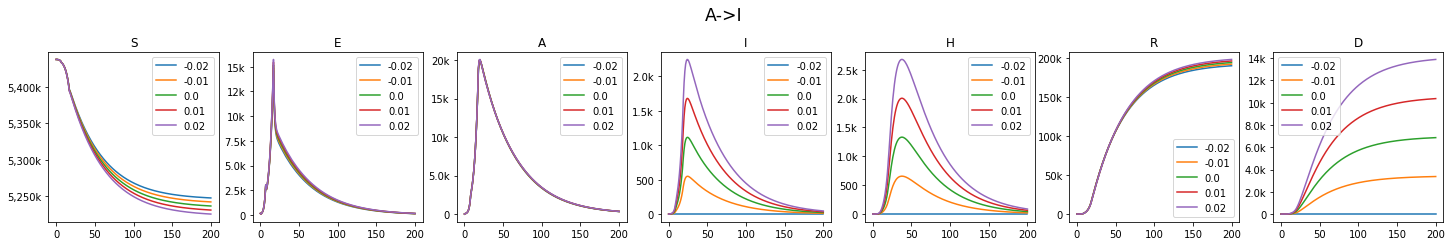

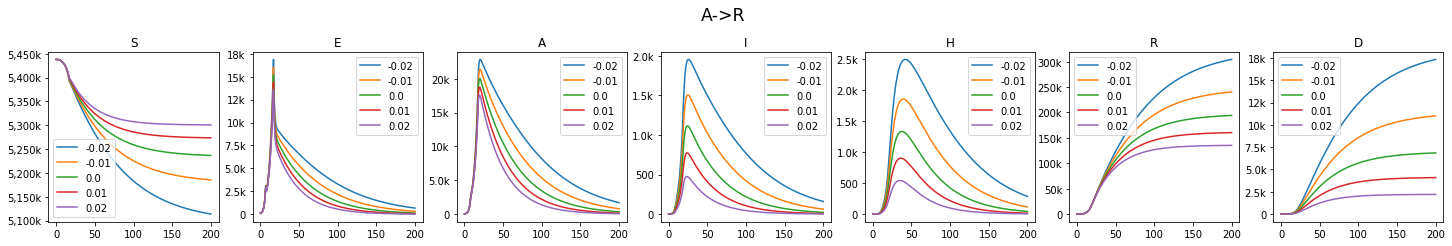

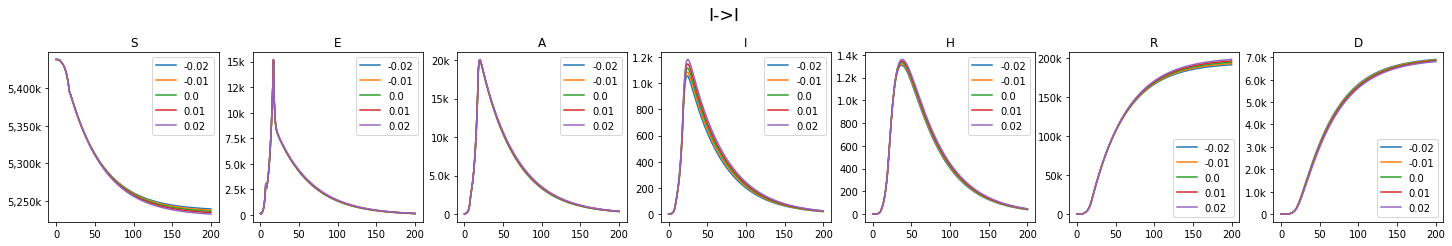

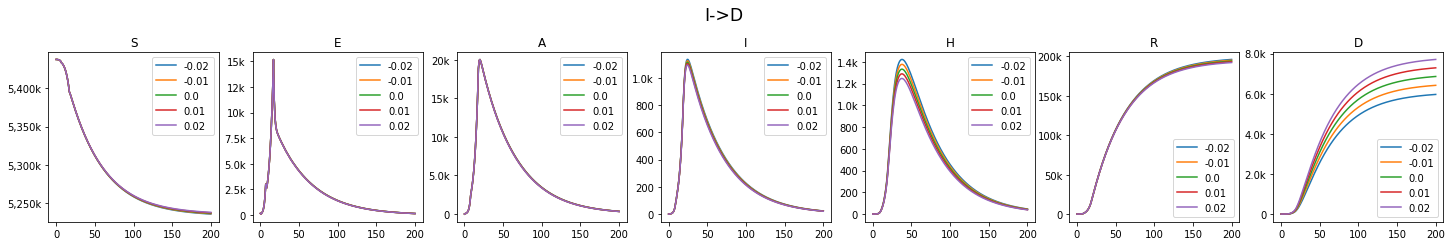

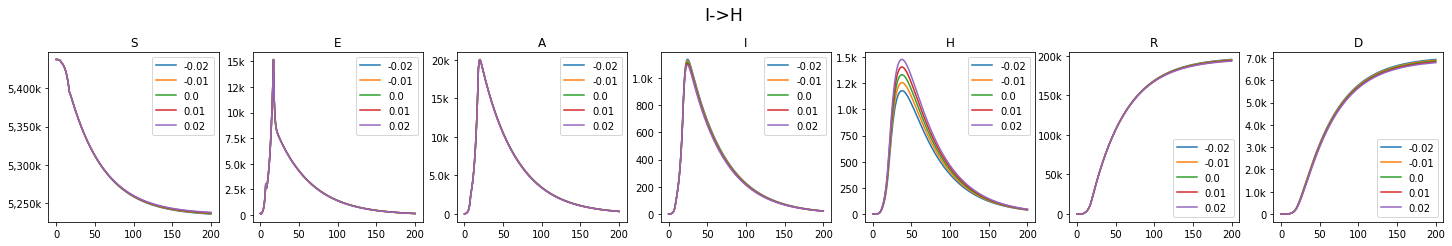

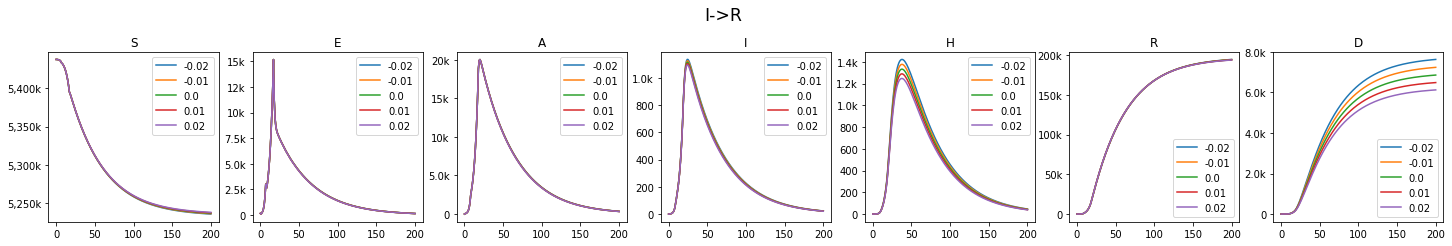

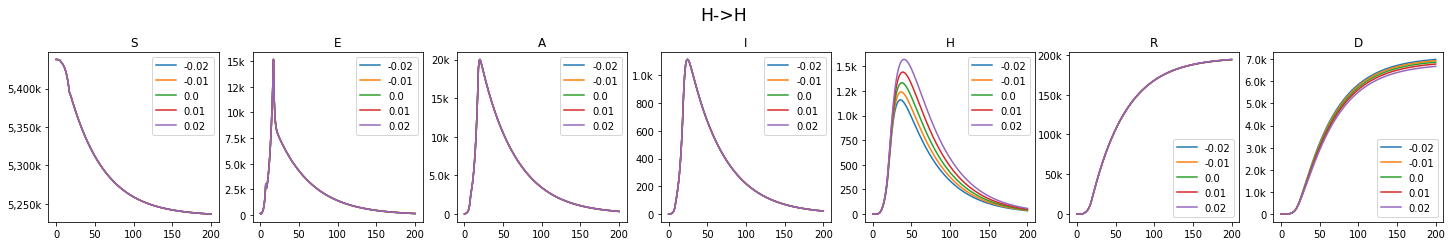

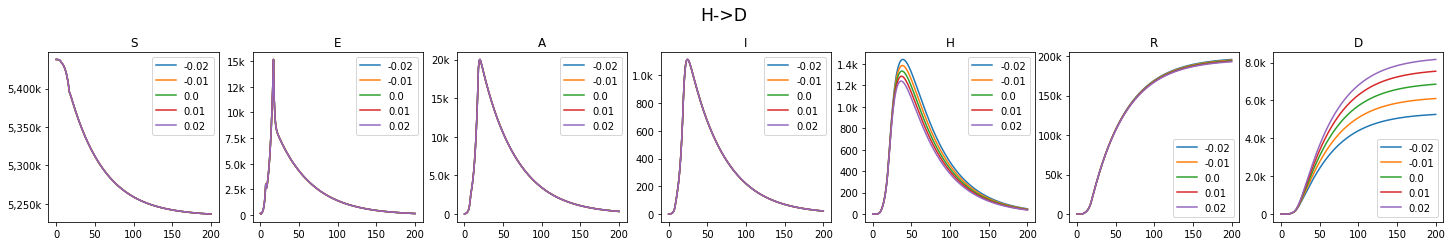

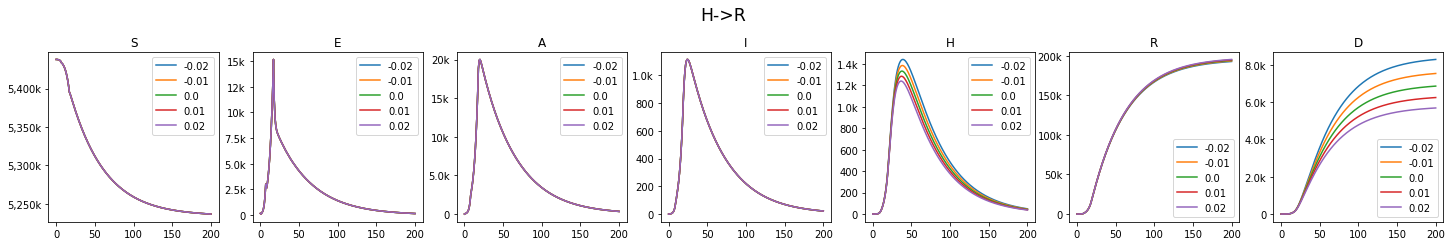

In [10]:
network = create_original_network(args)
initialInfections = get_initial_infections(args.input)

for compartment_1, values in network.progression['70+'].items():
    for compartment_2, proba in values.items():

        if proba == 1.:
            continue
        
        fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(25, 3.5), sharex=True)
        fig.suptitle(f"{compartment_1}->{compartment_2}", fontsize='xx-large')
        fig.subplots_adjust(top=0.8)
        
        for bump in [-0.02, -0.01, 0., 0.01, 0.02]:
            bumped_progression = bump_progression_field(args.compartment_transition, compartment_1, compartment_2, bump)
            bumped_network = create_network(bumped_progression, network.states, network.graph, network.infectionMatrix, network.movementMultipliers, network.infectiousStates)
            res = runSimulation(bumped_network, max_time, trials, initialInfections)
            res = aggregate_all_boards(res)

            for i, col in enumerate(['S', 'E', 'A', 'I', 'H', 'R', 'D']):
                res[col].plot(ax=axes[i], title=col, label=bump)
                axes[i].set_xlabel('')
                axes[i].legend()
                axes[i].yaxis.set_major_formatter(fmt)

### c) Sensitivity to infection matrix

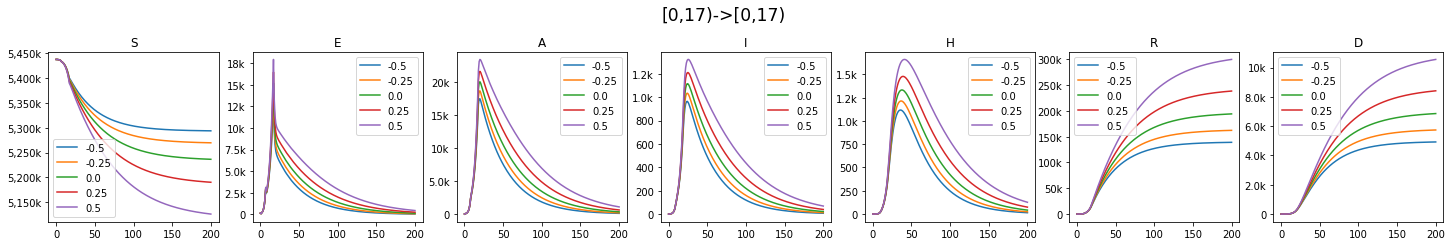

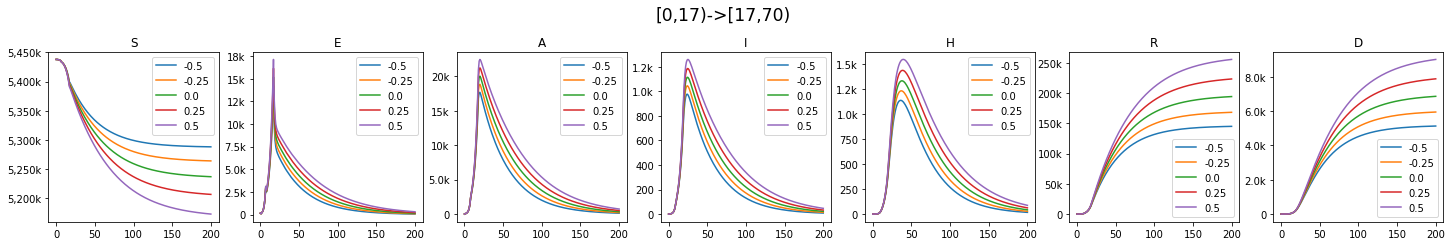

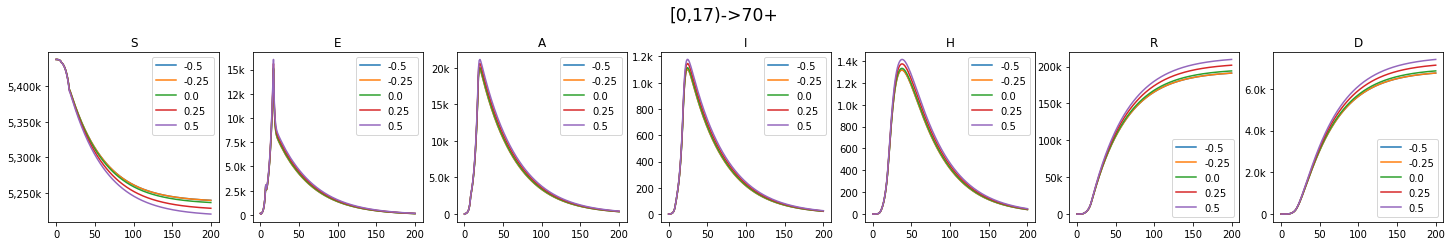

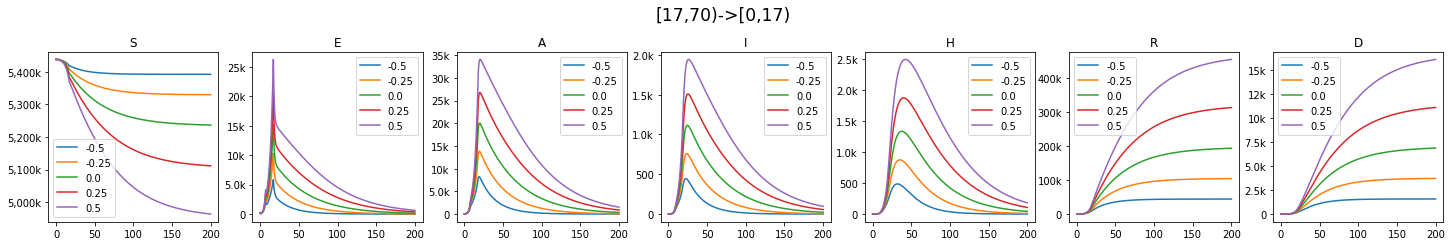

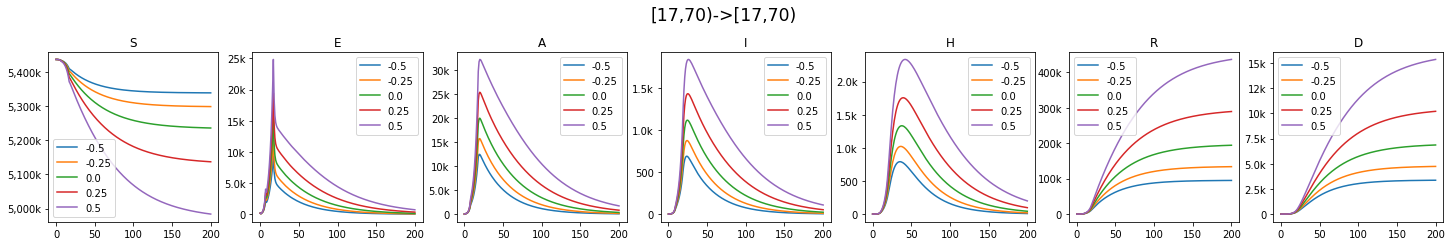

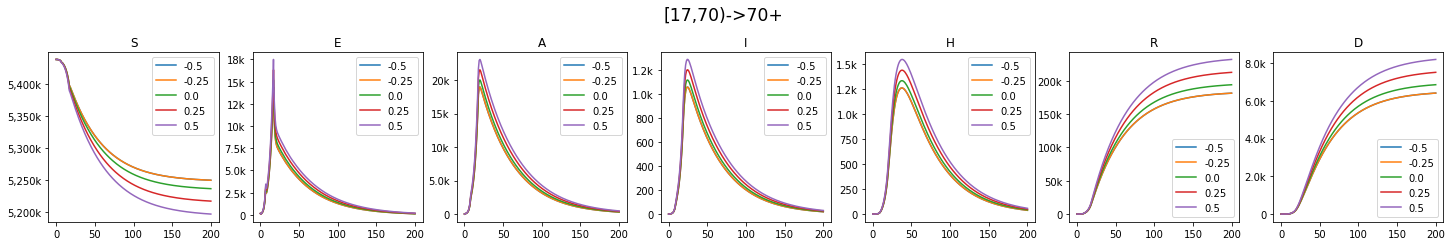

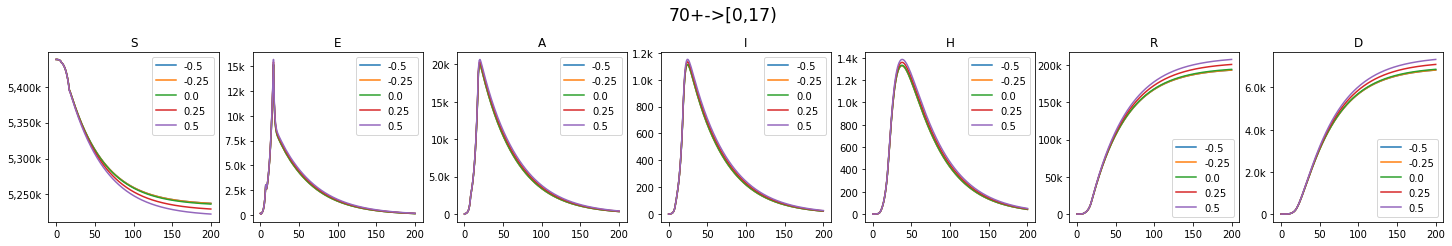

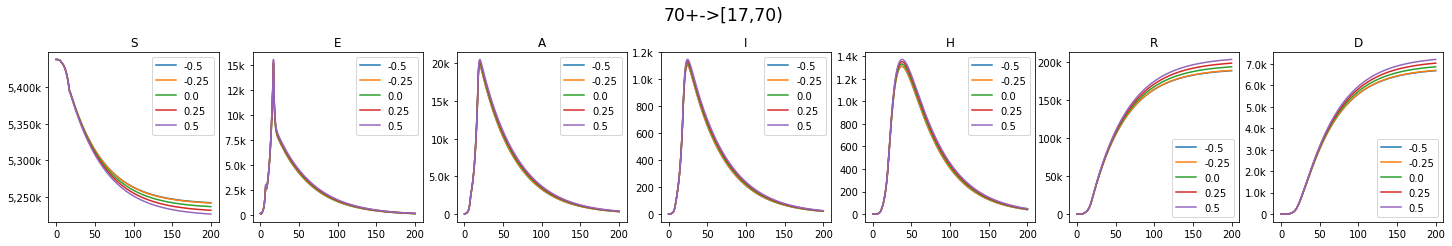

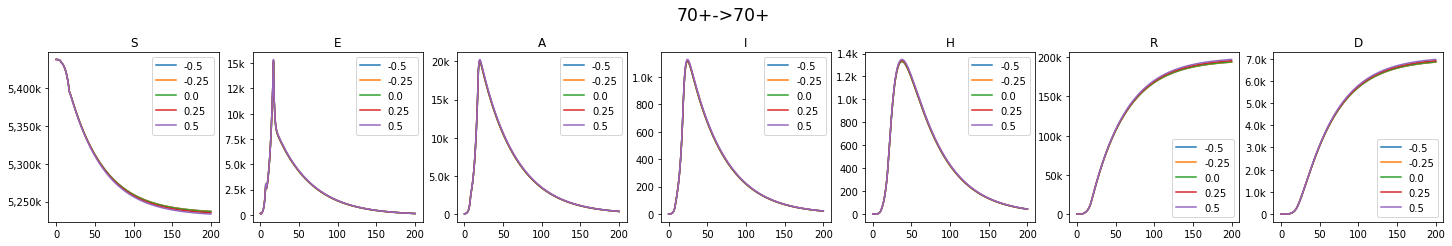

In [11]:
network = create_original_network(args)
initialInfections = get_initial_infections(args.input)

for age_range1, infection_row in network.infectionMatrix._matrix.items():
    for age_range2, contacts in infection_row._entries.items():
        
        fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(25, 3.5), sharex=True)
        fig.suptitle(f"{age_range1}->{age_range2}", fontsize='xx-large')
        fig.subplots_adjust(top=0.8)
        
        for bump in [-0.5, -0.25, 0., 0.25, 0.5]:
            infectionMatrix = bump_infection_matrix(network.infectionMatrix, age_range1, age_range2, bump)
            bumped_network = create_network(network.progression, network.states, network.graph, infectionMatrix, network.movementMultipliers, network.infectiousStates)
            res = runSimulation(bumped_network, max_time, trials, initialInfections)
            res = aggregate_all_boards(res)

            for i, col in enumerate(['S', 'E', 'A', 'I', 'H', 'R', 'D']):
                res[col].plot(ax=axes[i], title=col, label=bump)
                axes[i].set_xlabel('')
                axes[i].legend()
                axes[i].yaxis.set_major_formatter(fmt)

### d) Sensitivity to movement multipliers

Movement multiplier has little effect for small deviations, and needs to be bumped substantially before having a sizeable impact. There is not much difference in impact from a parallel change to a term structure tilt. We see that a sudden late change to the multiplier creates new waves of disease spread.

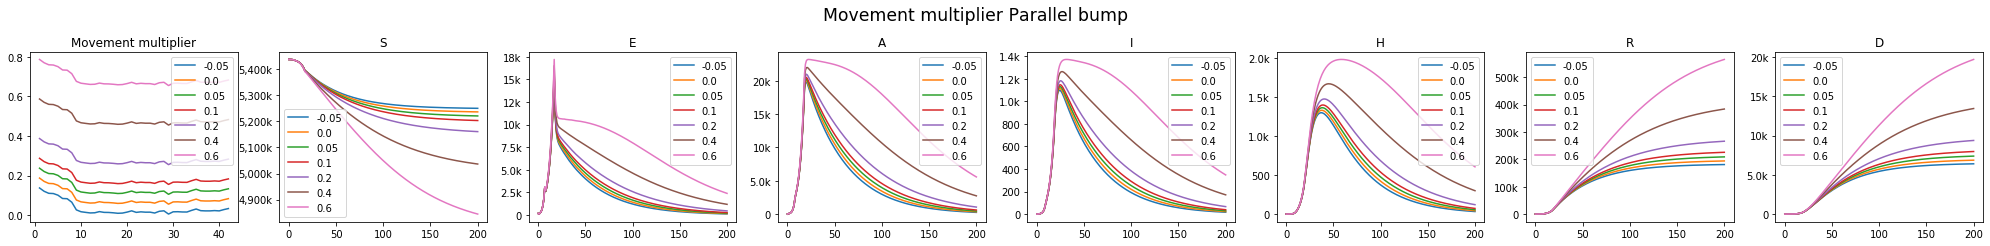

In [12]:
network = create_original_network(args)
initialInfections = get_initial_infections(args.input)

fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(35, 3.5))
fig.suptitle(f"Movement multiplier Parallel bump", fontsize='xx-large')
fig.subplots_adjust(top=0.8)

for bump in [-0.05, 0., 0.05, 0.1, 0.2, 0.4, 0.6]:
    movementMultipliers = bump_movement_multipliers(network.movementMultipliers, bump, 0)
    bumped_network = create_network(network.progression, network.states, network.graph, network.infectionMatrix, movementMultipliers, network.infectiousStates)
    res = runSimulation(bumped_network, max_time, trials, initialInfections)
    res = aggregate_all_boards(res)

    plot_movement_multiplier(axes[0], bump, movementMultipliers)
    
    for i, col in enumerate(['S', 'E', 'A', 'I', 'H', 'R', 'D']):
        res[col].plot(ax=axes[i + 1], title=col, label=bump)
        axes[i + 1].set_xlabel('')
        axes[i + 1].legend()
        axes[i + 1].yaxis.set_major_formatter(fmt)

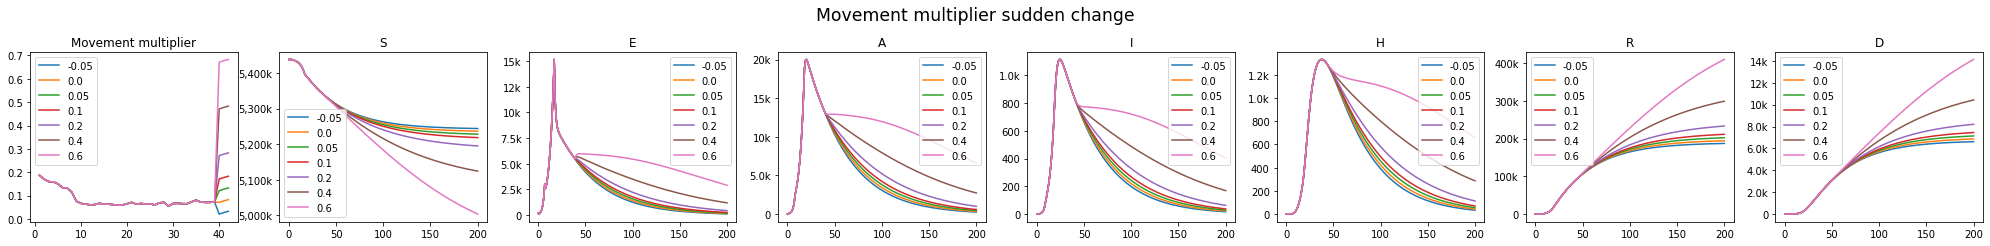

In [13]:
network = create_original_network(args)
initialInfections = get_initial_infections(args.input)

fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(35, 3.5))
fig.suptitle(f"Movement multiplier sudden change", fontsize='xx-large')
fig.subplots_adjust(top=0.8)

for bump in [-0.05, 0., 0.05, 0.1, 0.2, 0.4, 0.6]:
    movementMultipliers = bump_movement_multipliers(network.movementMultipliers, bump, 0, 40)
    bumped_network = create_network(network.progression, network.states, network.graph, network.infectionMatrix, movementMultipliers, network.infectiousStates)
    res = runSimulation(bumped_network, max_time, trials, initialInfections)
    res = aggregate_all_boards(res)

    plot_movement_multiplier(axes[0], bump, movementMultipliers)
    
    for i, col in enumerate(['S', 'E', 'A', 'I', 'H', 'R', 'D']):
        res[col].plot(ax=axes[i + 1], title=col, label=bump)
        axes[i + 1].set_xlabel('')
        axes[i + 1].legend()
        axes[i + 1].yaxis.set_major_formatter(fmt)

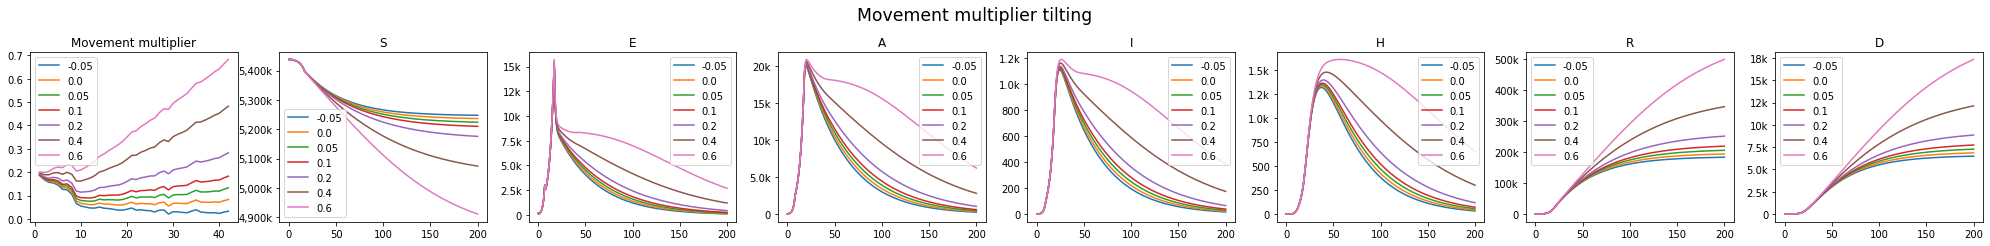

In [14]:
network = create_original_network(args)
initialInfections = get_initial_infections(args.input)

fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(35, 3.5))
fig.suptitle(f"Movement multiplier tilting", fontsize='xx-large')
fig.subplots_adjust(top=0.8)

for bump in [-0.05, 0., 0.05, 0.1, 0.2, 0.4, 0.6]:
    movementMultipliers = tilt_movement_multipliers(network.movementMultipliers, bump, 0)
    bumped_network = create_network(network.progression, network.states, network.graph, network.infectionMatrix, movementMultipliers, network.infectiousStates)
    res = runSimulation(bumped_network, max_time, trials, initialInfections)
    res = aggregate_all_boards(res)

    plot_movement_multiplier(axes[0], bump, movementMultipliers)
    
    for i, col in enumerate(['S', 'E', 'A', 'I', 'H', 'R', 'D']):
        res[col].plot(ax=axes[i + 1], title=col, label=bump)
        axes[i + 1].set_xlabel('')
        axes[i + 1].legend()
        axes[i + 1].yaxis.set_major_formatter(fmt)

### e) Sensitivity to contact multipliers

Contact multiplier is very impactful, even for small deviations. There is not much difference in impact from a parallel change to a term structure tilt, but we see that any sudden change up systematically creates subsequent waves.

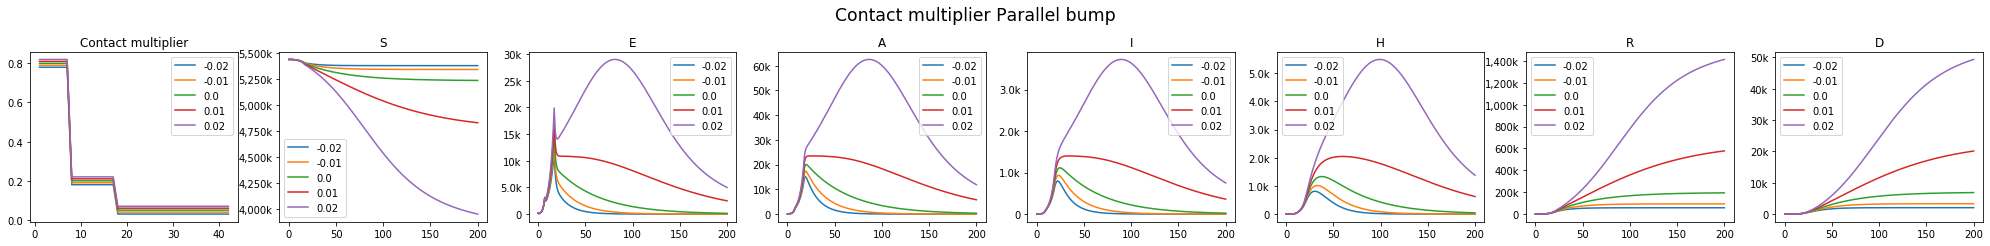

In [15]:
network = create_original_network(args)
initialInfections = get_initial_infections(args.input)

fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(35, 3.5))
fig.suptitle(f"Contact multiplier Parallel bump", fontsize='xx-large')
fig.subplots_adjust(top=0.8)

for bump in [-0.02, -0.01, 0., 0.01, 0.02]:
    movementMultipliers = bump_movement_multipliers(network.movementMultipliers, 0, bump)
    bumped_network = create_network(network.progression, network.states, network.graph, network.infectionMatrix, movementMultipliers, network.infectiousStates)
    res = runSimulation(bumped_network, max_time, trials, initialInfections)
    res = aggregate_all_boards(res)

    plot_contact_multiplier(axes[0], bump, movementMultipliers)
    
    for i, col in enumerate(['S', 'E', 'A', 'I', 'H', 'R', 'D']):
        res[col].plot(ax=axes[i + 1], title=col, label=bump)
        axes[i + 1].set_xlabel('')
        axes[i + 1].legend()
        axes[i + 1].yaxis.set_major_formatter(fmt)

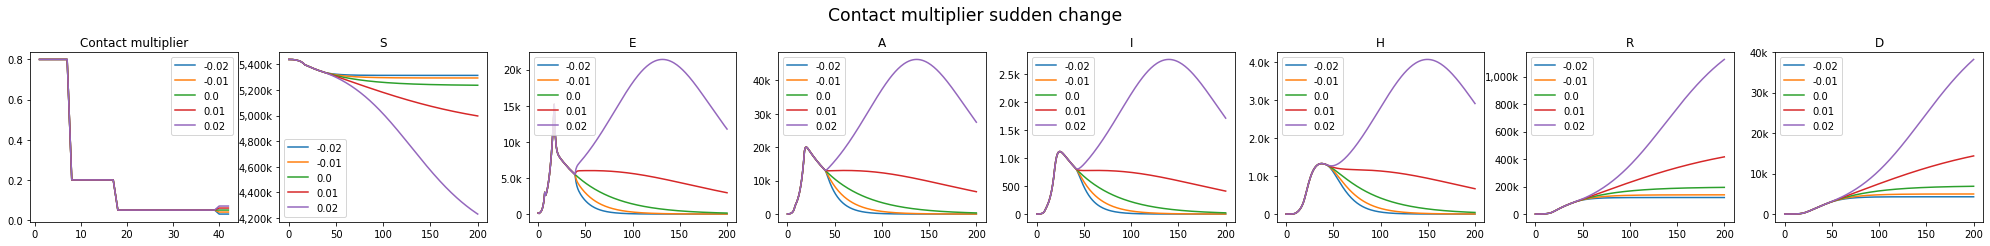

In [16]:
network = create_original_network(args)
initialInfections = get_initial_infections(args.input)

fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(35, 3.5))
fig.suptitle(f"Contact multiplier sudden change", fontsize='xx-large')
fig.subplots_adjust(top=0.8)

for bump in [-0.02, -0.01, 0., 0.01, 0.02]:
    movementMultipliers = bump_movement_multipliers(network.movementMultipliers, 0, bump, 40)
    bumped_network = create_network(network.progression, network.states, network.graph, network.infectionMatrix, movementMultipliers, network.infectiousStates)
    res = runSimulation(bumped_network, max_time, trials, initialInfections)
    res = aggregate_all_boards(res)

    plot_contact_multiplier(axes[0], bump, movementMultipliers)
    
    for i, col in enumerate(['S', 'E', 'A', 'I', 'H', 'R', 'D']):
        res[col].plot(ax=axes[i + 1], title=col, label=bump)
        axes[i + 1].set_xlabel('')
        axes[i + 1].legend()
        axes[i + 1].yaxis.set_major_formatter(fmt)

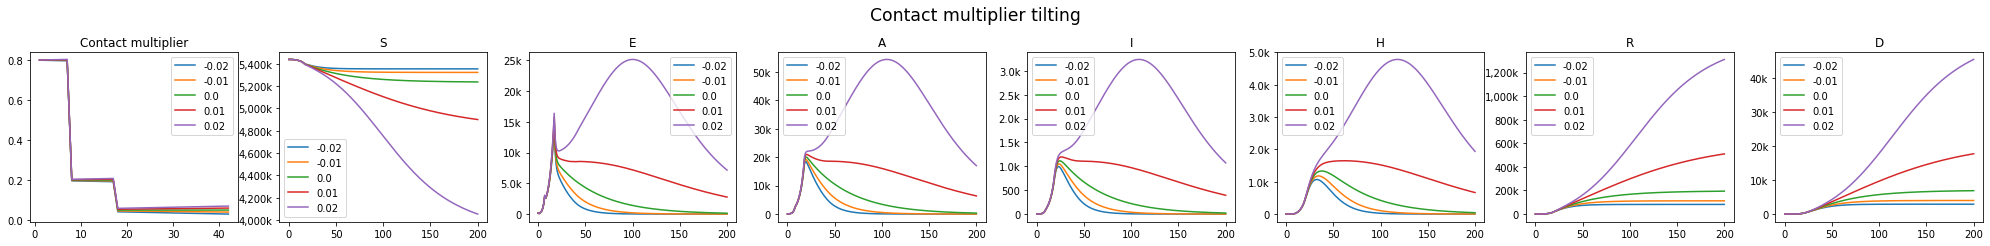

In [17]:
network = create_original_network(args)
initialInfections = get_initial_infections(args.input)

fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(35, 3.5))
fig.suptitle(f"Contact multiplier tilting", fontsize='xx-large')
fig.subplots_adjust(top=0.8)

for bump in [-0.02, -0.01, 0., 0.01, 0.02]:
    movementMultipliers = tilt_movement_multipliers(network.movementMultipliers, 0, bump)
    bumped_network = create_network(network.progression, network.states, network.graph, network.infectionMatrix, movementMultipliers, network.infectiousStates)
    res = runSimulation(bumped_network, max_time, trials, initialInfections)
    res = aggregate_all_boards(res)

    plot_contact_multiplier(axes[0], bump, movementMultipliers)
    
    for i, col in enumerate(['S', 'E', 'A', 'I', 'H', 'R', 'D']):
        res[col].plot(ax=axes[i + 1], title=col, label=bump)
        axes[i + 1].set_xlabel('')
        axes[i + 1].legend()
        axes[i + 1].yaxis.set_major_formatter(fmt)